# CIS 522 Final Project
## Indian Classical Music Generation
Shrivats Kannan, Saaketh Narayan

# Section 1. Imports and Setup

In [ ]:
!pip install librosa
!sudo apt install -y fluidsynth
!pip install midi2audio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 41 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0ubuntu1 [8,596 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic/uni

In [ ]:
import os
import sys
import random
import numpy as np
import glob
import pickle
import numpy
import soundfile as sf
import librosa
import librosa.display
from midi2audio import FluidSynth
import string
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from music21 import converter, instrument, note, chord, stream, duration

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from google.colab import drive
drive.mount('/content/drive')
seed = 525

Mounted at /content/drive


# Section 2. MIDI Input Processing for Generative Model

The inputs to the generative model are MIDI files that are converted to array format similar to piano roll. The output is also in this piano roll format, which can then be converted back to MIDI.

In [ ]:
class MidiDataset(data.Dataset):
  def __init__(self, midi_files=[]):
    self.notes = self.get_notes(midi_files=midi_files)
    self.length = 25
    self.midi_source = midi_files
        
  def __len__(self):
    return len(self.notes) - self.length*2

  def __getitem__(self, index):
    samples = self.notes[index:(index+self.length*2)]
    x=np.asarray(samples).astype(np.float32)
    return (x[0:self.length,:],x[self.length:,:])
      
  def get_notes(self, midi_files):
    notes = []
    for i,file in enumerate(midi_files):
      midi = converter.parse(file)
      print("Parsing %s" % file)
      
      try: #midi events are not flat
        events = instrument.partitionByInstrument(midi)
        notes_to_parse = events.parts[0].recurse() 
      except: # midi inputs are flattened
        notes_to_parse = midi.flat.notes

      #initialize note matrix
      length=int(notes_to_parse[-1].offset*4)+1
      notes_song=np.zeros((length,88))

      for element in notes_to_parse:
          if isinstance(element, note.Note):
            # we only care about note or chord events
            notes_song[int(element.offset*4),(element.pitch.midi-21)]=1.0    
            notes_song[(int(element.offset*4)+1):(int(element.offset*4)+int(element.duration.quarterLength*4)),(element.pitch.midi-21)+1]=1.0 
          elif isinstance(element, chord.Chord):
            for note_in_chord in element.pitches:
              notes_song[int(element.offset*4),(note_in_chord.midi-21)]=1.0   
              notes_song[(int(element.offset*4)+1):(int(element.offset*4)+int(element.duration.quarterLength*4)),(note_in_chord.midi-21)+1]=1.0     
      notes+=[list(i) for i in list(notes_song)]
    return notes

def create_midi(prediction_output, midiOutputFile='test_output.mid'):
  offset = 0
  output_notes = []

  # create note objects
  for i,pattern in enumerate(prediction_output):
    notes = []
    noteIndex = np.where(pattern==1)[0]
    noteIndex = noteIndex[[ii % 1 ==0 for ii in noteIndex]]
    if len(noteIndex)>0:  
      for current_note in noteIndex:
        new_note = note.Note(int(current_note/1 + 21))
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset
        output_notes.append(new_note)

    offset += 1.0/4

  midi_stream = stream.Stream(output_notes)
  midi_stream.write('midi', fp=midiOutputFile)
  print("created midi file: ",midiOutputFile )

# Section 3. Set up Train, Validation, and Test DataLoaders for Generative Model

In [ ]:
os.chdir("/content/drive/MyDrive/522_Final_Project_MIDI/full_midi_dataset")
midi_files_list = glob.glob("*.mid")

# split total_dataset into training, validation, and test 
data_len_train = 10
data_len_val = 5
data_len_test = 5
data_len_pred = 1

random.seed( seed  )
midi_files_sel = random.sample(midi_files_list, (data_len_train + data_len_val + data_len_test + data_len_pred))
train_files, val_files, test_files, pred_files = midi_files_sel[:data_len_train], midi_files_sel[data_len_train:(data_len_train + data_len_val)], midi_files_sel[(data_len_train + data_len_val):(data_len_train + data_len_val + data_len_pred)], midi_files_sel[(data_len_train + data_len_val + data_len_pred):(data_len_train + data_len_val + data_len_pred + 1)]

train_dataset=MidiDataset(midi_files=train_files)
training_generator = data.DataLoader(train_dataset, batch_size=50, shuffle=True)

val_dataset=MidiDataset(midi_files=val_files)
val_generator = data.DataLoader(val_dataset, batch_size=50, shuffle=True)

test_dataset=MidiDataset(midi_files=test_files)
test_generator = data.DataLoader(test_dataset, batch_size=50, shuffle=True)

pred_dataset=MidiDataset(midi_files=pred_files)
pred_generator = data.DataLoader(pred_dataset, batch_size=50, shuffle=True)

# # print(len(train_dataset), len(test_dataset))


Parsing Copy of Miyan ki  Malhar.mid
Parsing Copy of Puriya Kalyan.mid
Parsing Copy of Durga.mid
Parsing Copy of Bhupal Todi.mid
Parsing Copy of JaunaPuri.mid
Parsing Copy of Abhogi.mid
Parsing Copy of Bahar.mid
Parsing Copy of Behag.mid
Parsing Copy of Puriya Dhanashri.mid
Parsing Copy of Peelu.mid
Parsing Copy of Adana.mid
Parsing Copy of Asavari.mid
Parsing Copy of Chandra Kauns.mid
Parsing Copy of Tilang.mid
Parsing Copy of Jogiyagenerated.mid
Parsing Copy of Bhairav.mid
Parsing Copy of Basant.mid


# Section 4. Simple DL Model

This model is based of a Seq2One architecture with Cross Entropy Loss.

In [ ]:
class SimpleLSTM(nn.Module):
  def __init__(self, input_dim, rnn_dim=512, rnn_layers=2):
    super(SimpleLSTM, self).__init__()
    self.rnn = nn.LSTM( input_size=input_dim, hidden_size=rnn_dim, num_layers=rnn_layers, batch_first=True, dropout=0.2)
    self.classifier = nn.Sequential(
      nn.Linear(rnn_dim, 256),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(256, input_dim)
    )
    self.loss_function = nn.BCEWithLogitsLoss()
      
  def forward(self, x):          
    output, (hn, cn) = self.rnn(x)
    return self.classifier(output[:,-1,:]) 
    
  def loss(self, x,y):
    y_pred = y.argmax(dim=1)
    return self.loss_function(x,y_pred)
  
  def accuracy(self, x, y):
    x_pred = x.argmax(dim=1)
    y_pred = y.argmax(dim=1)
    return (x_pred == y_pred).float().mean()

# Section 5. Generative Model Architecture


We use two LSTM layers and a two fully connected linear layers, as well as the BCEWithLogitsLoss, which combines a sigmoid layer with the BCELoss. It is inspired by a Seq2Seq architecture.

In [ ]:
class NMModel(nn.Module):
  def __init__(self, input_dim=88, rnn_dim=512, num_layers=2):
    super(NMModel, self).__init__()

    self.pr_dim=input_dim
    self.rnn_dim=rnn_dim
    self.num_layers=num_layers

    self.encoder = nn.LSTM( input_size=self.pr_dim, hidden_size=self.rnn_dim,
                           num_layers=self.num_layers, batch_first=True, dropout=0.25)
    self.decoder = nn.LSTM( input_size=self.pr_dim, hidden_size=self.rnn_dim,
                           num_layers=self.num_layers, batch_first=True, dropout=0.25)
    self.classifier = nn.Sequential(
      nn.Linear(self.rnn_dim, 256),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(256, self.pr_dim)
      )

    self.loss_function = nn.BCEWithLogitsLoss() 

  def forward(self, x, y):
    #padding          
    x_zeros = torch.zeros(x.shape[0], 1, x.shape[2]).to(device)
    x = torch.cat([x_zeros,x], dim=1)
    output, (hn, cn) = self.encoder(x)
    length = y.shape[1]

    outputs = torch.zeros(y.shape[0], length, self.pr_dim).to(device)

    #more padding
    y_zeros = torch.zeros(y.shape[0], 1, y.shape[2]).to(device)
    y = torch.cat([y_zeros,y], dim=1)

    input = y[:,0,:].view(y.shape[0],1,y.shape[2])

    #teacher forcing loop
    for timestep in range(1, length):
      output, (hn, cn) = self.decoder(input, (hn, cn))
      tf_flag = random.random() < 0.5 
      shape = output.shape

      x=output.unsqueeze(2)
      x = self.classifier(x)
      x = x.view(shape[0],shape[1],-1)

      output = (x > 0).float()
      input = (y[:,timestep,:].view(y.shape[0],1,y.shape[2]) if tf_flag else output.view(y.shape[0],1,y.shape[2]))

      outputs[:,timestep,:] = x.view(y.shape[0],-1)

    return outputs
  
  def loss(self, x,y):
    x = x.view(-1,x.shape[2])
    y_pred = y.view(-1,y.shape[2])
    return self.loss_function(x,y_pred)
  
  def accuracy(self, x, y):
    x_pred = x.argmax(dim=1)
    y_pred = y.argmax(dim=1)
    return (x_pred == y_pred).float().mean()

# Section 6. Generative Model Training Loop

In [ ]:
#Training
model = NMModel()
model = model.to(device)
epochs = 50
learning_rate = 0.0025
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

loss_train=[]
acc_train=[]
loss_val=[]
acc_val=[]

for epoch in range(epochs):
  for i,batch in enumerate(training_generator):
    x = batch[0]
    y = batch[1]
    x= x.to(device)
    y= y.to(device)
    y_pred = model.train()(x, y)

    loss = model.loss(y_pred, y)
    acc  = model.accuracy(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_train.append(loss.item())
  acc_train.append(acc.item())

  if epoch%10==0:
    for i, batch in enumerate(val_generator):
      loss_list = []
      acc_list = []
      x = batch[0]
      y = batch[1]
      x= x.to(device)
      y= y.to(device)
      y_pred = model.eval()(x,y)

      # Compute and print loss
      loss = model.loss(y_pred, y)
      loss_list.append(loss.item())
      acc = model.accuracy(y_pred, y)
      acc_list.append(acc.item())
  else:
    loss_list.append(loss_list[-1])
    acc_list.append(acc_list[-1])
    
  loss_val.append(np.asarray(loss_list).mean())
  acc_val.append(np.asarray(acc_list).mean())

  print(epoch, loss_train[epoch], loss_val[epoch], acc_train[epoch], acc_val[epoch])

0 0.06844256073236465 0.07497228682041168 0.9340277910232544 0.9378787875175476
1 0.06912870705127716 0.07497228682041168 0.9277146458625793 0.9378787875175476
2 0.06973469257354736 0.07497228682041168 0.9365530014038086 0.9378787875175476
3 0.07018547505140305 0.07497228682041168 0.9343434572219849 0.9378787875175476
4 0.06983769685029984 0.07497228682041168 0.9321338534355164 0.9378787875175476
5 0.07114514708518982 0.07497228682041168 0.9412878751754761 0.9378787875175476
6 0.06860145926475525 0.07497228682041168 0.9324495196342468 0.9378787875175476
7 0.06885257363319397 0.07497228682041168 0.9416035413742065 0.9378787875175476
8 0.0669688880443573 0.07497228682041168 0.933080792427063 0.9378787875175476
9 0.07010848075151443 0.07497228682041168 0.9352903962135315 0.9378787875175476
10 0.06806716322898865 0.07720483839511871 0.941919207572937 0.9287878274917603
11 0.06924673914909363 0.07720483839511871 0.9327651262283325 0.9287878274917603
12 0.06975789368152618 0.0772048383951187

In [ ]:
torch.save(model, '/content/drive/MyDrive/522_Final_Project_MIDI/generative_50epoch.pt')

Graphing Training and Validation Loss

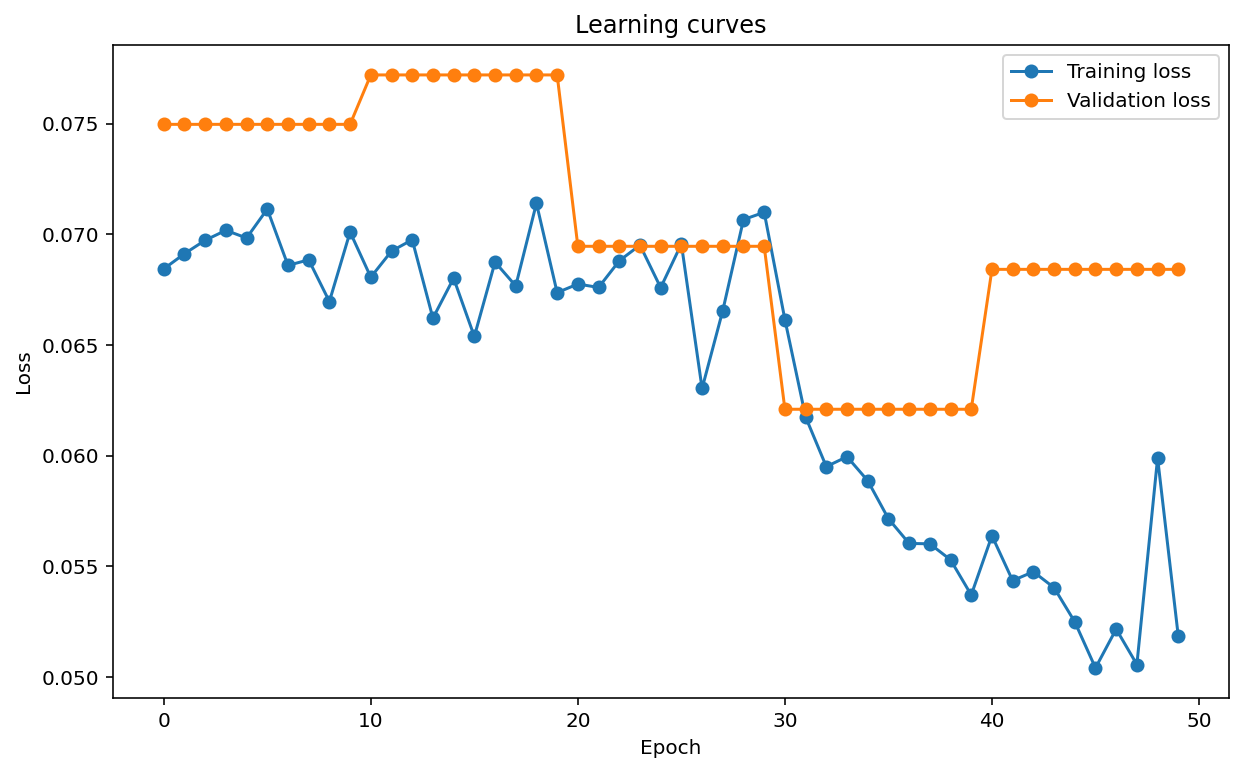

In [ ]:
graph_epochs = range(epochs)

plt.figure(figsize=(10,6))
plt.plot(graph_epochs, loss_train, '-o', label='Training loss')
plt.plot(graph_epochs, loss_val, '-o', label='Validation loss')

plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Graphing Training and Validation Accuracy

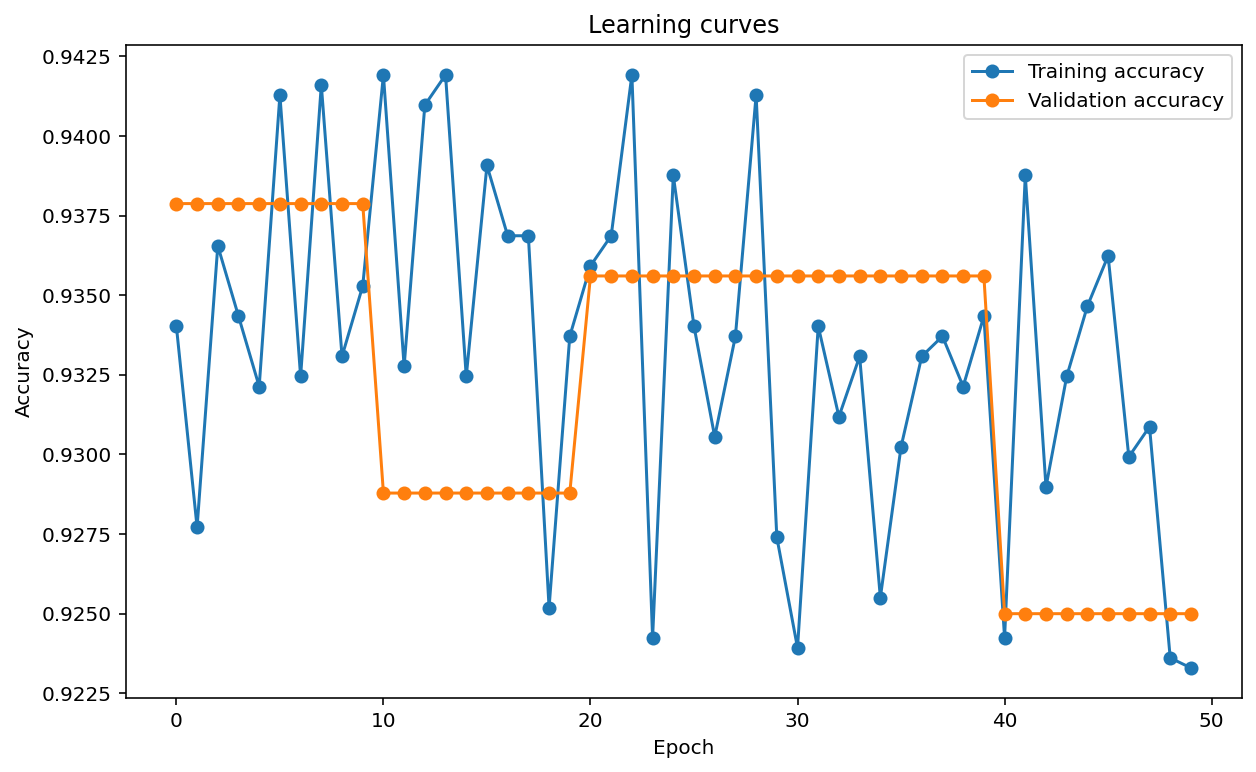

In [ ]:
graph_epochs = range(epochs)

plt.figure(figsize=(10,6))
plt.plot(graph_epochs, acc_train, '-o', label='Training accuracy')
plt.plot(graph_epochs, acc_val, '-o', label='Validation accuracy')

plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Section 7. Generative Model Testing

In [ ]:
def test(test_generator):
  loss_test=[]
  acc_test=[]

  for i,batch in enumerate(test_generator):
    x = batch[0]
    y = batch[1]
    x= x.to(device)
    y= y.to(device)
    y_pred = model.eval()(x,y)
    
    # Compute and print loss
    loss = model.loss(y_pred, y)
    acc  = model.accuracy(y_pred, y)
    
    loss_test.append(loss.item())
    acc_test.append(acc.item())

  print(np.asarray(loss_test).mean(), np.asarray(acc_test).mean())
  print(np.asarray(loss_test).std(), np.asarray(acc_test).std())

test(test_generator)

0.056788191689472446 0.941774601999082
0.0021847510149643045 0.003986274213091763


# Section 8. Generating Music with DL Model



In [ ]:
def predict(x, y, pred_seq=1):
  z = x.to(device)
  w = y.to(device)
  x1shape = x.shape[1]
  pred_shape=list(x.shape[1:])
  pred_shape[0] += pred_seq*pred_shape[0]
  pred_test=np.zeros(pred_shape)
  pred_test[0:x1shape,:] = x[0,:,:].numpy() 
  for i in range(pred_seq):
    y_pred = model.eval()(z,w)
    y_pred_pos=y_pred[0,:,:].argmax(dim=1).cpu().numpy()
    for ii in range(len(y_pred_pos)):
      pred_test[x1shape + ii,y_pred_pos[ii]] = 1.0
  return pred_test

In [ ]:
print(pred_files)

for i,batch in enumerate(pred_generator):
  xinit = batch[0][0:1,:,:]
  yinit = batch[1][0:1,:,:]

pred_test = predict(xinit, yinit)

['Copy of Basant.mid']


Creating output midi file from prediction

In [ ]:
def create_midi(prediction, midiOutputFile):
  offset = 0
  output_notes = []

  for i,pattern in enumerate(prediction):
    notes = []
    noteIndex = np.where(pattern==1)[0]
    if len(noteIndex)>0:  
      for curr_note in noteIndex:
        new_note = note.Note(int(curr_note + 21))
        new_note.storedInstrument = instrument.Flute() #arbitrary instrument
        new_note.offset = offset
        output_notes.append(new_note)
    offset += 1.0/4

  midi_stream = stream.Stream(output_notes)
  midi_stream.write('midi', fp=midiOutputFile)
  print("created midi file: ",midiOutputFile )

prefix = os.path.splitext(pred_files[0])[0]
output_notes = create_midi(pred_test, '/content/drive/MyDrive/522_Final_Project_MIDI/generated_midi/'+prefix+"_generated.mid")

created midi file:  /content/drive/MyDrive/522_Final_Project_MIDI/generated_midi/Copy of Basant_generated.mid


# Section 9. Traditional ML Benchmark


The traditional ML benchmark here repeatedly samples a probability distribution of notes based on pitch and duration that it has constructed from the input.

In [ ]:
#create probability distribution of notes
length = 88
pitch_distribution = [0 for i in range(88)]
duration_distribution = [0 for i in range(100)] 

for i,file in enumerate(pred_files):
  midi = converter.parse(file)
  print("Parsing %s" % file)
  
  try: #midi events are not flat
    events = instrument.partitionByInstrument(midi)
    notes_to_parse = events.parts[0].recurse() 
  except: # midi inputs are flattened
    notes_to_parse = midi.flat.notes
  
  for element in notes_to_parse:
    if isinstance(element, note.Note):
      pitch_distribution[element.pitch.midi-21]+=1
      duration_distribution[int(element.duration.quarterLength*4)]+=1

    elif isinstance(element, chord.Chord):
      for note_in_chord in element.pitches:
        pitch_distribution[note_in_chord.midi-21]+=1
      duration_distribution[int(element.duration.quarterLength*4)]+=1

flattened_pitch_distribution = []
for i, value in enumerate(pitch_distribution):
  for ii in range(value):
    flattened_pitch_distribution.append(i)

flattened_duration_distribution = []
for i, value in enumerate(duration_distribution):
  for ii in range(value):
    flattened_duration_distribution.append(i)



Parsing Copy of Basant.mid


Graph of pitch distribution

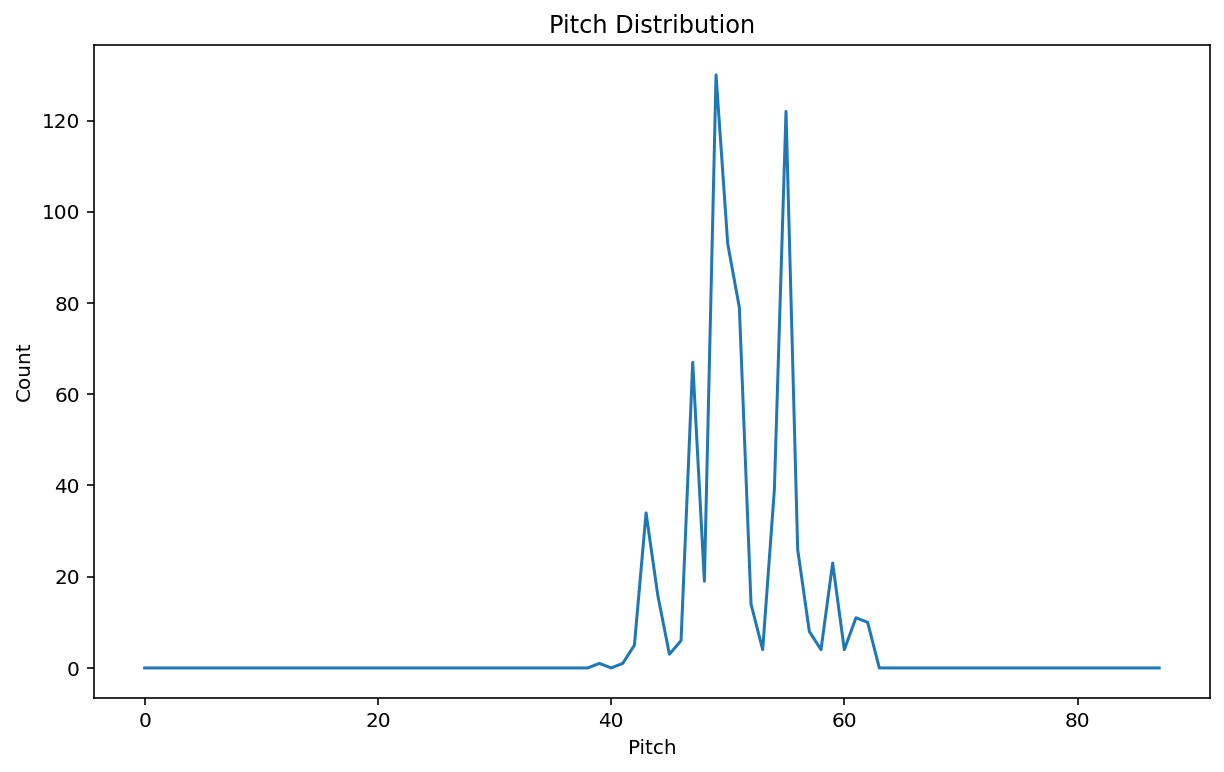

In [ ]:
#plot of pitch distribution
plt.figure(figsize=(10,6))
plt.plot(pitch_distribution)

plt.title('Pitch Distribution')
plt.xlabel('Pitch')
plt.ylabel('Count')
plt.show()

Graph of duration distribution

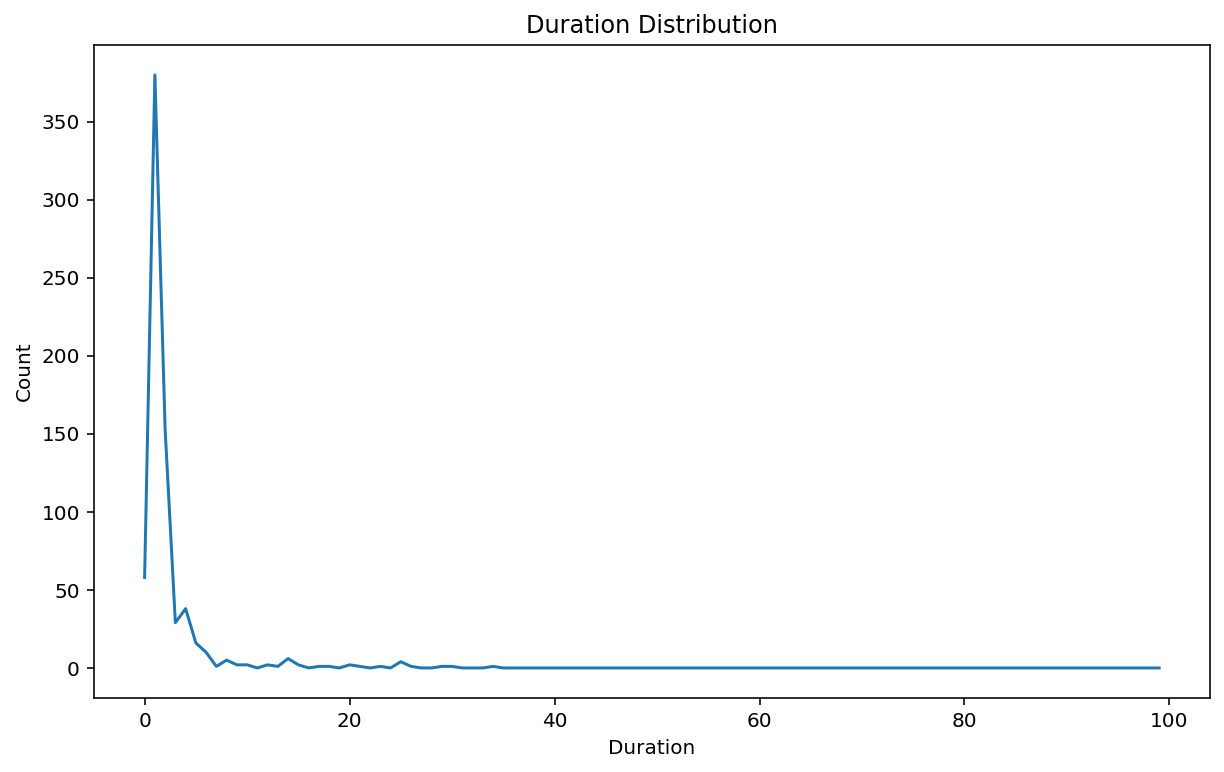

In [ ]:
#plot of duration distribution
plt.figure(figsize=(10,6))
plt.plot(duration_distribution)

plt.title('Duration Distribution')
plt.xlabel('Duration')
plt.ylabel('Count')
plt.show()

Now we also generate a sample using the traditional ML probability distribution approach.

In [ ]:
#sample from distributions to make predicted sequence
sequence_length = 25
predicted_sequence_traditional = []

for i in range(sequence_length):
  new_note = np.random.choice(flattened_pitch_distribution)
  new_duration = np.random.choice(flattened_duration_distribution)
  predicted_sequence_traditional.append([new_note, new_duration])

In [ ]:
def create_midi_traditional(prediction, midiOutputFile):
  offset = 0
  output_notes = []

  for i, curr_note in enumerate(prediction):
    new_note = note.Note(int(curr_note[0] + 21))
    new_note.storedInstrument = instrument.Flute() #arbitrary instrument
    new_note.offset = offset
    new_note.duration = duration.Duration(curr_note[1]/4)
    output_notes.append(new_note)
    offset += curr_note[1]/4

  midi_stream = stream.Stream(output_notes)
  midi_stream.write('midi', fp=midiOutputFile)
  print("created midi file: ",midiOutputFile )

basename = pred_files[0].split(".")[0]
create_midi_traditional(predicted_sequence_traditional, '/content/drive/MyDrive/522_Final_Project_MIDI/generated_midi/'+basename+"_traditional.mid")

created midi file:  /content/drive/MyDrive/522_Final_Project_MIDI/generated_midi/Copy of Basant_traditional.mid


# Section 10: MIDI-to-Audio Conversion Network

This class takes MIDI files as input, converts them to wav files using the FluidSynth library, then converts the wav file to a mel frequency spectrogram. The target output is also a wav file converted to a mel frequency spectrogram.

In [ ]:
class MidiAudioDataset(data.Dataset):
  def __init__(self, seq_len=10, midi_files=[]):
    self.seq_len = seq_len
    self.notes = self.get_notes(midi_files=midi_files)
    self.midi_source = midi_files

  #get total number of samples
  def __len__(self):
    return len(self.notes)

  #get one sample of data
  def __getitem__(self, index):
    x, y = self.notes[index]
    x = torch.FloatTensor(x)
    y = torch.tensor(y)
    return (x,y)

  #get notes and chords from midi files, get wav representation from wav files
  def get_notes(self, midi_files):
    notes = []
    specs = []
    data = []
    for i, fname in enumerate(midi_files):
      notes_melody=[]

      outdir = "/content/drive/MyDrive/522_Final_Project_MIDI/"

      name_wav = outdir + "intermediate_wavs/" + fname.split(".")[0] + "_interm.wav"

      FluidSynth(outdir+"sound_font.sf2", sample_rate=11025).midi_to_audio(fname, name_wav)

      y2, sam2 = librosa.load(name_wav, sr=11025)
      mel2 = librosa.feature.melspectrogram(y2, sr=11025)
      mel2 = mel2.T

      spec_len2 = mel2.shape[0]

      mydir = "/content/drive/MyDrive/522_Final_Project_MIDI/"

      name = fname.split('.')[0] + ".wav"
      filename = mydir + "new_raga_guide_wav/" + name

      print(filename)

      y, sam = librosa.load(filename, sr=11025)
      mel = librosa.feature.melspectrogram(y, sr=11025)
      mel = mel.T

      spec_len = mel.shape[0]

      print(spec_len2)
      print(spec_len)

      if(spec_len2 > spec_len):
        mel2 = mel2[:spec_len]
      
      if(spec_len > spec_len2):
        mel = mel[:spec_len2]

      spec_len2 = mel2.shape[0]
      spec_len = mel.shape[0]


      for i in range(spec_len - self.seq_len + 1):
        notes.append((mel2[i:i+self.seq_len], mel[i:i+self.seq_len].flatten()))
    
    return notes

# Section 11. Dataloader and Model Architecture for MIDI-to-Audio Conversion Network

Setting up dataloader for MIDI conversion network, and processing samples.

In [ ]:
os.chdir("/content/drive/MyDrive/522_Final_Project_MIDI/new_raga_guide_midi")
mydir = "/content/drive/MyDrive/522_Final_Project_MIDI/new_raga_guide_midi/"
midi_files_list = glob.glob("*.mid")
#midi_files_list = ["Abhogi.mid"]
print(midi_files_list)
train_size = int(1 * len(midi_files_list))
test_size = len(midi_files_list) - train_size
train_midis, test_midis = torch.utils.data.random_split(midi_files_list, [train_size, test_size])

train_dataset=MidiAudioDataset(midi_files=midi_files_list)
training_generator = data.DataLoader(train_dataset, batch_size=4, shuffle=True)

['Abhogi.mid', 'Asavari.mid', 'Basant.mid', 'Bhairav.mid', 'Bhairavi.mid', 'Bhupal Todi.mid', 'Bhupali.mid', 'Bilaskhani Todi.mid', 'Desh.mid', 'Jogiya.mid', 'Kafi.mid', 'Kirvani.mid', 'Lalit.mid', 'Malkauns.mid', 'Manj Khamaj.mid', 'Pilu.mid', 'Puriya Dhanashri.mid', 'Puriya Kalyan.mid']
/content/drive/MyDrive/522_Final_Project_MIDI/new_raga_guide_wav/Abhogi.wav
1594
1601
/content/drive/MyDrive/522_Final_Project_MIDI/new_raga_guide_wav/Asavari.wav
2111
2113
/content/drive/MyDrive/522_Final_Project_MIDI/new_raga_guide_wav/Basant.wav
2240
2241
/content/drive/MyDrive/522_Final_Project_MIDI/new_raga_guide_wav/Bhairav.wav
2370
2385
/content/drive/MyDrive/522_Final_Project_MIDI/new_raga_guide_wav/Bhairavi.wav
1853
1857
/content/drive/MyDrive/522_Final_Project_MIDI/new_raga_guide_wav/Bhupal Todi.wav
1982
1985
/content/drive/MyDrive/522_Final_Project_MIDI/new_raga_guide_wav/Bhupali.wav
1939
1953
/content/drive/MyDrive/522_Final_Project_MIDI/new_raga_guide_wav/Bilaskhani Todi.wav
2154
2161
/co

Model architecture for the conversion network consists of two convolutional layers followed by four fully connected linear layers with ReLU activation functions and dropout. The network outputs the corresponding spectrogram slice for an input spectrogram slice.

In [ ]:
class MIDIAudioNet(nn.Module):
  def __init__(self, kernel=None, padding=0):
    super(MIDIAudioNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=2, padding=padding)
    self.c1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=2, padding=padding)
    self.l1 = nn.ReLU()
    self.l2 = nn.Linear(8064, 17000)
    self.l5 = nn.Dropout(p=0.5)
    self.l3 = nn.ReLU()
    self.l4 = nn.Linear(17000, 13000)
    self.l5 = nn.Dropout(p=0.5)
    self.l6 = nn.ReLU()
    self.l7 = nn.Linear(13000, 7000)
    self.l8 = nn.ReLU()
    self.l9 = nn.Linear(7000, 128*10)
            
  def forward(self, x):

        # feed x into model:
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.c1(x)
        x = self.conv2(x)
        x = x.view(x.shape[0], -1)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = self.l6(x)
        x = self.l7(x)
        x = self.l8(x)
        x = self.l9(x)
        
        return x


# Section 12. Training loop for conversion network

Define training function for conversion network.

In [ ]:
from tqdm.notebook import tqdm

def train(model, device, train_loader, epochs, criterion, optimizer):

    train_loss = []
    for epoch in range(epochs):
        model.train()
        
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
              data, target = data.to(device), target.to(device)

              output = model(data)

              optimizer.zero_grad()
              loss = criterion(output, target)
              loss.backward()
              optimizer.step()

              tepoch.set_postfix(loss = loss.item())
        
              train_loss.append(loss.item())

    return train_loss

In [ ]:
torch.cuda.empty_cache()
midinet = MIDIAudioNet().to(device)
criterion = nn.HuberLoss(delta=0.5)
learning_rate = 0.0001
optimizer = torch.optim.Adam(midinet.parameters(), learning_rate)
num_epochs = 20
train_loss = train(midinet, device, training_generator, num_epochs, criterion, optimizer)
torch.save(midinet, '/content/drive/MyDrive/522_Final_Project_MIDI/conversion_20epoch.pt')

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

  0%|          | 0/8491 [00:00<?, ?batch/s]

Graphing training loss

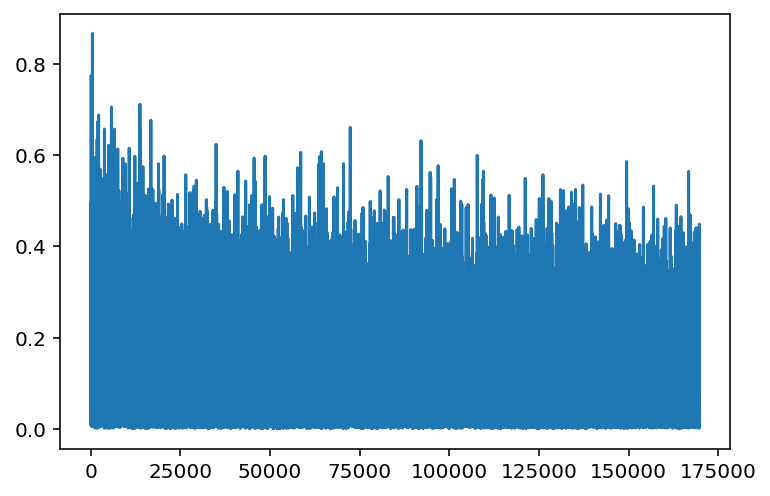

In [ ]:
plt.plot(train_loss)

# Section 13. Converting MIDI to audio with the conversion network

The network has tried to learn how to convert input MIDI to audio in the style of Indian classical flute. Replace the file path below to convert an example.

In [ ]:
#outputting -- averaging over windows.
myfile = "/content/drive/MyDrive/522_Final_Project_MIDI/new_raga_guide_midi/Basant.mid"
outdir = "/content/drive/MyDrive/522_Final_Project_MIDI/"
name_wav = outdir + "intermediate_wavs/" + myfile.split("/")[-1].split(".")[0] + "_interm.wav"
print(name_wav)
FluidSynth(outdir+"sound_font.sf2", sample_rate=11025).midi_to_audio(myfile, name_wav)
res, _ = librosa.load(name_wav, sr=11025)
spec = librosa.feature.melspectrogram(res, sr=11025)
spec = spec.T

output = np.zeros(spec.T.shape)
num_data = np.zeros(spec.T.shape[1])

for i in range(len(spec) - 10 + 1):
  x = torch.FloatTensor(spec[i:i+10])
  #print(x.shape)
  x = x.unsqueeze(0).to(device)
  res = midinet(x)
  res = res.cpu()
  res = res.view(res.shape[0], 10, 128).detach().numpy()
  res = np.squeeze(res)
  res = res.T
  act_res = np.zeros(output.shape)
  act_res[:,i:i+10] = res
  output = output + act_res
  act_num_data = np.zeros(num_data.shape)
  act_num_data[i:i+10] = np.asarray([1]*10)
  num_data = num_data + act_num_data

output = np.divide(output, num_data)

/content/drive/MyDrive/522_Final_Project_MIDI/intermediate_wavs/Basant_interm.wav


Graph of mel frequency spectrogram for input and output

[Text(0.5, 1.0, 'Mel-frequency spectrogram of output')]

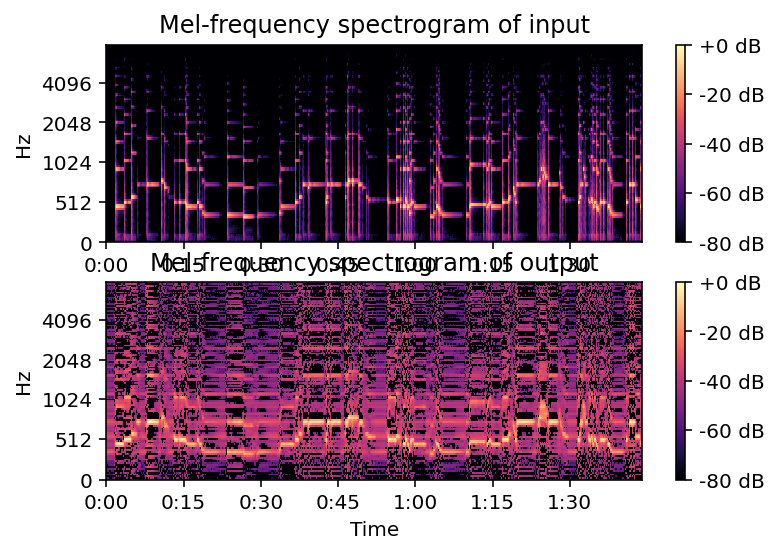

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1)

S_dB2 = librosa.power_to_db(spec.T, ref=np.max)
img2 = librosa.display.specshow(S_dB2, x_axis='time',
                         y_axis='mel', sr=11025,
                         fmax=8000, ax=ax1)
fig.colorbar(img2, ax=ax1, format='%+2.0f dB')
ax1.set(title='Mel-frequency spectrogram of input')

S_dB = librosa.power_to_db(output, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=11025,
                         fmax=8000, ax=ax2)
fig.colorbar(img, ax=ax2, format='%+2.0f dB')
ax2.set(title='Mel-frequency spectrogram of output')

Uncomment to convert mel frequency spectrogram to wav audio and save file.

In [ ]:
#real_out = librosa.feature.inverse.mel_to_audio(output, sr=11025)
#sf.write('/content/drive/MyDrive/522_Final_Project_MIDI/generated_wav/Basant_generated.wav', real_out, 11025)

And that wraps up our code! We were able to generate relevant improvisation based on input Indian classical MIDI and its characteristics, and then convert that to audio resembling the Indian classical flute style. Our models do have limitations, which we discuss further in our paper. Overall, we really enjoyed working on this project and thank you for a great semester in CIS 522!